In [1]:
import numpy as np;
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv
from math import log
import scipy.io as spio



In [2]:

# Load the training dataset
mat = spio.loadmat('train_data.mat', squeeze_me=True)
train = mat['x_train'][:40000] # data
trainlabels = mat['x_train_labs'][:40000] # labels

valid =  mat['x_train'][40000:]
validlabels = mat['x_train_labs'][40000:]

mat2 = spio.loadmat('test_data.mat', squeeze_me=True)
test = mat2['x_test'] # data
testlabels = mat2['x_test_labs'] # labels



x_train = np.zeros((40000,3072))
x_valid = np.zeros((10000,3072))
x_test = np.zeros((10000,3072))

#Normalising the data between 0 and 1.
for i in range (train.shape[0]):
    x_train[i] = (train[i]-min(train[i]))/(max(train[i])-min(train[i]))
    
for i in range (test.shape[0]):
    x_test[i] = (test[i]-min(test[i]))/(max(test[i])-min(test[i]))

    
for i in range (valid.shape[0]):
    x_valid[i] = (valid[i]-min(valid[i]))/(max(valid[i])-min(valid[i]))


n_samples, img_size = x_train.shape

# The cifar-10 contains the digits 1 to 10 so we will set the number of labels as 10
nlabels = 10

In [3]:
y_train = np.zeros((trainlabels.shape[0], nlabels))
y_test  = np.zeros((testlabels.shape[0], nlabels))
y_valid  = np.zeros((validlabels.shape[0], nlabels))



#Assigning labels
for i in range(0,trainlabels.shape[0]):
    y_train[i, trainlabels[i].astype(int)-1]=1
    
for i in range(0,testlabels.shape[0]):    
    y_test[i, testlabels[i].astype(int)-1]=1
    
for i in range (0,validlabels.shape[0]):
    y_valid[i, validlabels[i].astype(int)-1]=1

In [12]:
# The number of epochs is a hyperparameter that defines the number times that the learning algorithm 
# will work through the entire training dataset.

# The batch size is a hyperparameter that defines the number of samples to work through before 
# updating the internal model parameters. 

# ref: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

n_epoch = 10
n_batches = 100
batch_size = math.ceil(n_samples/n_batches)


# define the size of each of the layers in the network
n_input_layer  = img_size
n_hidden_layer = 30
n_output_layer = nlabels

# Add another hidden layer
n_hidden_layer2 = 0 # number of neurons of the second hidden layer. 0 deletes this layer

#Set to 'True' if you want to use sigmoid and 'False' for ReLu/Softmax 
sigmoid = False

# eta is the learning rate
eta = 0.04 # if using sigmoid set a higher learning rate like 0.25

In [13]:
# Initialize a simple network
# For W1 and W2 columns are the input and the rows are the output.
# W1: Number of columns (input) needs to be equal to the number of features 
#     of the  cifar-10 images, thus p. Number of rows (output) should be equal 
#     to the number of neurons of the hidden layer thus n_hidden_layer.
# W2: Number of columns (input) needs to be equal to the number of neurons 
#     of the hidden layer. Number of rows (output) should be equal to the 
#     number of digits we wish to find (classification).

Xavier_init=True

if Xavier_init:
    W1 = np.random.randn(n_hidden_layer, n_input_layer) * np.sqrt(2 / (n_input_layer))
    if n_hidden_layer2>0:
        W2 = np.random.randn(n_hidden_layer2, n_hidden_layer) * np.sqrt(2 / (n_hidden_layer))
        W3 = np.random.randn(n_output_layer, n_hidden_layer2) * np.sqrt(2 / (n_hidden_layer2))
    else:
        W2 = np.random.randn(n_output_layer, n_hidden_layer) * np.sqrt(2 / (n_hidden_layer))
else:
    W1 = np.random.uniform(0,1,(n_hidden_layer, n_input_layer))
    W2 = np.random.uniform(0,1,(n_output_layer, n_hidden_layer))

    # The following normalises the random weights so that the sum of each row =1
    W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,n_input_layer))
    W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,n_hidden_layer))

    if n_hidden_layer2>0:
        W3=np.random.uniform(0,1,(n_output_layer,n_hidden_layer2))
        W3=np.divide(W3,np.matlib.repmat(np.sum(W3,1)[:,None],1,n_hidden_layer2))

        W2=np.random.uniform(0,1,(n_hidden_layer2,n_hidden_layer))
        W2=np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,n_hidden_layer))

In [14]:
# Initialize the biases
# The bias acts as the offset for the activation function.
# To keep the input to activation function for each layer
# close to zero we shall initialise the bias to minus the  
# input mean. For the hidden layer this is will be approximately 
# 0.5 as the previous layer activation should be around sigmoid(0.0).

bias_W1 = np.ones((n_hidden_layer,))*(-x_train.mean())
bias_W2 = np.ones((n_output_layer,))*(-0.5)

if n_hidden_layer2>0:    
    bias_W3=np.ones((n_output_layer,))*(-0.5)
    bias_W2=np.ones((n_hidden_layer2,))*(-0.5)

# Keep track of the network inputs and average error per epoch
errors=np.zeros((n_epoch,))
valerrors=np.zeros((n_epoch,))

In [15]:


#function that computes the softmax distribution of an array
def softmax(O):
    return np.exp(O)/np.sum(np.exp(O))


#Function that computes Cross Entropy Loss 
#between the desired output and the prediction of the final layer
def cross_entropy(desired,predicted):
    E=0
    for i in range (predicted.shape[0]):
        E -= desired[i]*np.log(predicted[i])
    return E


  
#ReLU function that returns 0 if a number is lower than 0
#and the number itself if it higher than 0
def relu(x):
    for i in range(x.shape[0]):
        x[i] = max(0,x[i])    
    return x


#Function that computes the derivative of the ReLU function
#Returns 0 if an number is lower than 0 and 1 if it is larger than 0
def red(x):
    for i in range (x.shape[0]):
        if (x[i]>0):
            x[i] = 1
        else:
            x[i] = 0
            
    return x


n = x_valid.shape[0]


In [16]:
# Train the network
for i in range(0,n_epoch):
    # We will shuffle the order of the samples each epoch
    shuffled_idxs = np.random.permutation(n_samples)
    
    for batch in range(0,n_batches):
        # Initialise the gradients for each batch
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)

        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        if n_hidden_layer2 > 0:
            dW3 = np.zeros(W3.shape)
            dbias_W3 = np.zeros(bias_W3.shape)

        # Loop over all the samples in the batch
        for j in range(0,batch_size):

            # Input (random element from the dataset)
            idx = shuffled_idxs[batch*batch_size + j]
            x = x_train[idx]
            
            # Form the desired output, the correct neuron should have 1 the rest 0
            desired_output = y_train[idx]

            
            # Neural activation: input layer -> hidden layer
            act1 = np.dot(W1,x)+bias_W1
          

            # Apply the activation function
            if(sigmoid == True):
                out1 = 1/(1+np.exp(-act1))
            else:
                out1 = relu(act1)
            
            
            
            # Neural activation: hidden layer -> output layer
            act2 = np.dot(W2,out1)+bias_W2
          
           # Apply the activation function
            if(sigmoid == True):
                out2 = 1/(1+np.exp(-act2))
            elif(n_hidden_layer2 > 0):
                out2 = relu(act2)
            else:
                out2 = softmax(act2)
            
            if n_hidden_layer2 > 0:
                # Neural activation: hidden layer 1 -> hidden layer 2
                act3 = np.dot(W3,out2)+bias_W3

                # Apply the sigmoid function
                if(sigmoid == True):
                    out3 = 1/(1+np.exp(-act3))
                else:
                    out3 = softmax(act3)
                
                # Compute the error signal
                e_n = desired_output - out3
                
                # Backpropagation: output layer -> hidden layer 2
                if sigmoid == True:
                    out3delta = out3*(1-out3) * e_n
                else:
                    out3delta =  e_n
                
                dW3 += np.outer(out3delta,out2)
                dbias_W3 += out3delta
                
                # Backpropagation: hidden layer -> input layer
                if sigmoid == True:
                    out2delta = out2*(1-out2) * np.dot(W3.T, out3delta)
                else:
                    out2delta = red(out2) * np.dot(W3.T, out3delta)
                
            else:
                # Compute the error signal
                e_n =  -(out2 - desired_output)
                
                # Backpropagation: output layer -> hidden layer
                if sigmoid == True:
                    out2delta = out2*(1-out2) * e_n
                else:
                    out2delta = e_n
                
            dW2 += np.outer(out2delta, out1)
            dbias_W2 += out2delta

            # Backpropagation: hidden layer -> input layer
            if sigmoid == True:
                out1delta = out1*(1-out1) * np.dot(W2.T, out2delta)
            else:
                out1delta = red(out1) * np.dot(W2.T, out2delta)
            dW1 += np.outer(out1delta,x)
            dbias_W1 += out1delta
                 
            # Store the error per epoch
            if n_hidden_layer2 > 0:
                errors[i] = errors[i] + cross_entropy(desired_output, out3)/n_samples
            else:
                errors[i] = errors[i] + cross_entropy(desired_output, out2)/n_samples

            
       
        # After each batch update the weights using accumulated gradients         
        W2 += eta*dW2/batch_size
        W1 += eta*dW1/batch_size

        bias_W1 += eta*dbias_W1/batch_size
        bias_W2 += eta*dbias_W2/batch_size
        
        if n_hidden_layer2 > 0:
            W3 += eta*dW3/batch_size
            bias_W3 += eta*dbias_W3/batch_size
    print( "Epoch ", i+1, ": error = ", errors[i])
    
    #calculating the error on the validation set
    for v in range(0, n):
        x = x_valid[v]
        y = y_valid[v]

        act1 = np.dot(W1, x) + bias_W1
        if sigmoid == True:
            out1 = 1/(1+np.exp(-act1))
        else:
            out1 = relu(act1)
            
        if n_hidden_layer2 > 0:    
            act2 = np.dot(W2, out1) + bias_W2
            if (sigmoid == True):
                out2 = 1 / (1 + np.exp(-act2))
            else:
                out2 = red(act2)

            act3 = np.dot(W3, out2) + bias_W3    
            
            if sigmoid == True:
                out3 = 1 / (1 + np.exp(-act3))
            else:
                out3 = softmax(act3)
    
        else:        
            act2 = np.dot(W2, out1) + bias_W2
            if sigmoid == True:
                out2 = 1 / (1 + np.exp(-act2))
            else:
                out2 = softmax(act2)  
            
        if n_hidden_layer2 > 0:    
            valerrors[i] = valerrors[i] + cross_entropy(y, out3)/n_samples
        else:
            valerrors[i] = valerrors[i] + cross_entropy(y, out2)/n_samples
    #stop early if validation error starts to increase
    if (i>5 and i%5==0 and valerrors[i]>valerrors[i-5]):
        break
    print("Validation Error = ", valerrors[i])





Epoch  1 : error =  2.1857583874261235
Validation Error =  0.5117363643285148
Epoch  2 : error =  1.981069338782693
Validation Error =  0.507281724119328
Epoch  3 : error =  1.9021410559378682
Validation Error =  0.4928711437577187
Epoch  4 : error =  1.8480569649785268
Validation Error =  0.47378974176019795
Epoch  5 : error =  1.8231022524332834
Validation Error =  0.45014366297449937
Epoch  6 : error =  1.7994385775342674
Validation Error =  0.4564321482573465
Epoch  7 : error =  1.776463123404802
Validation Error =  0.447483096217056
Epoch  8 : error =  1.765181649218341
Validation Error =  0.4390026944942221
Epoch  9 : error =  1.753879468941167
Validation Error =  0.4416883373623045
Epoch  10 : error =  1.7445946444947589
Validation Error =  0.4454749468952505


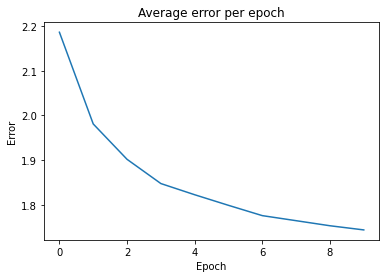

In [17]:
# Plot the performance
plt.plot(errors, label = 'error')

plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Average error per epoch')
plt.show()

[0.51173636 0.50728172 0.49287114 0.47378974 0.45014366 0.45643215
 0.4474831  0.43900269 0.44168834 0.44547495]


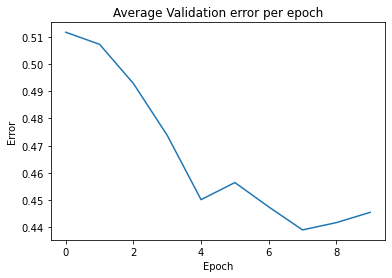

In [18]:
plt.plot(valerrors)
print(valerrors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Average Validation error per epoch')
plt.show()

In [19]:
#Computing the accuracy using the test set
n = x_test.shape[0]

p_ra = 0
correct_value = np.zeros((n,))
predicted_value = np.zeros((n,))

for i in range(0, n):
    x = x_test[i]
    y = y_test[i]
    correct_value[i] = np.argmax(y)

    act1 = np.dot(W1, x) + bias_W1
    out1 = relu(act1)
    #print(out1)
    if n_hidden_layer2 > 0:    
        act2 = np.dot(W2, out1) + bias_W2
        if sigmoid == True:
            out2 = 1 / (1 + np.exp(-act2))
        else:
            out2 = red(act2)

        act3 = np.dot(W3, out2) + bias_W3
        if sigmoid == True:
            out3 = 1 / (1 + np.exp(-act3))
        else:
            out3 = softmax(act3)

        predicted_value[i] = np.argmax(out3)
    
    else:        
        act2 = np.dot(W2, out1) + bias_W2
        if(sigmoid == True):
            out2 = 1 / (1 + np.exp(-act2))
        else:    
            out2 = softmax(act2)
       
        predicted_value[i] = np.argmax(out2)
    if predicted_value[i] == correct_value[i]: 
        p_ra = (p_ra + 1)

accuracy = 100*p_ra/n 
print("Accuracy = ", accuracy)

Accuracy =  36.56
